In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import GridSearchCV, HalvingRandomSearchCV
from sklearn.ensemble import GradientBoostingRegressor, BaggingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample

from mapie.regression import MapieRegressor
from mapie.metrics import regression_coverage_score

import xgboost as xgb


import matplotlib.pyplot as plt

In [2]:
# from sklearn.datasets import fetch_california_housing
# X, y = fetch_california_housing(return_X_y=True, as_frame=True)

In [2]:
df_cal = pd.read_csv('data/housing.csv')

# drop if less than 50k house value
df_cal = df_cal.query('median_house_value >= 50000')

X_train, X_test, y_train, y_test = train_test_split(
    df_cal.dropna().drop(['median_house_value', 'ocean_proximity'], axis=1),
    df_cal.dropna()['median_house_value'],
    test_size=0.2,
    random_state=0
)

In [4]:
# df_cal.drop(['median_house_value', 'ocean_proximity'], axis=1).describe().T

In [3]:
y_train, y_test = np.log(y_train), np.log(y_test) # made visual a bit harder to read when exponentiated

## MAPIE

In [4]:
lr_ca = MapieRegressor(LinearRegression()).fit(X_train, y_train)

In [5]:
lr_ca.predict(X_test)

array([12.18182306, 11.78830378, 12.53525512, ..., 11.81888349,
       13.00368924, 12.0835285 ], shape=(4048,))

In [6]:
y_pred, yp_conf_ci = lr_ca.predict(X_test, alpha=0.1)

In [7]:
yp_conf_ci.shape

(4048, 2, 1)

In [8]:
# y_pred, yp_conf_ci = lr_ca.predict(X_test, alpha=[.05, 0.1])

# coverage_scores = [
#     regression_coverage_score(np.asarray(y_test.reset_index(drop=True)), yp_conf_ci[:, 0, i], yp_conf_ci[:, 1, i])
#     for i, _ in enumerate([.05, .1])
# ]

# coverage_scores

In [9]:
yp_conf_ci = pd.DataFrame(yp_conf_ci[:,:,0], columns=['lower', 'upper']).reset_index(drop=True)

/var/folders/x6/4jhswqxj0sqf_gkgq6lw6l880000gn/T/ipykernel_82493/1638071256.py:17: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  yp_conf_ci.iloc[order]['lower'].ravel(),
/var/folders/x6/4jhswqxj0sqf_gkgq6lw6l880000gn/T/ipykernel_82493/1638071256.py:18: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  yp_conf_ci.iloc[order]['upper'].ravel(),


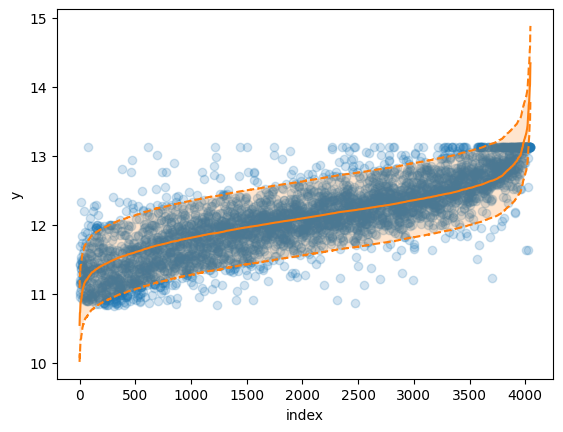

In [10]:
from matplotlib import pyplot as plt
y = y_test
y.reset_index(drop=True, inplace=True)

idx = np.arange(len(y_pred))
order = np.argsort(y_pred)

plt.xlabel("index")
plt.ylabel("y")
plt.scatter(idx, y[order], alpha=0.2)
order = np.argsort(y_pred)
plt.plot(idx, y_pred[order], color="C1")
plt.plot(idx, yp_conf_ci.iloc[order]['lower'], color="C1", ls="--")
plt.plot(idx, yp_conf_ci.iloc[order]['upper'], color="C1", ls="--")
plt.fill_between(
    idx,
    yp_conf_ci.iloc[order]['lower'].ravel(),
    yp_conf_ci.iloc[order]['upper'].ravel(),
    alpha=0.2
)
# plt.title(
#     f"Target and effective coverages for "
#     f"alpha={alpha[0]:.2f}: ({1-alpha[0]:.3f}, {coverage_scores[0]:.3f})\n"
#     f"Target and effective coverages for "
#     f"alpha={alpha[1]:.2f}: ({1-alpha[1]:.3f}, {coverage_scores[1]:.3f})"
# )
plt.show()

## OLS

In [11]:
import statsmodels.api as sm 

ols_fit = sm.OLS(y_train, sm.add_constant(X_train)).fit()

In [12]:
# ols_fit.predict(sm.add_constant(X_test)) #.confint(alpha=0.1)

yp_ols = (
    ols_fit
    .get_prediction(sm.add_constant(X_test))
    .summary_frame(alpha=0.1)
    .reset_index(drop=True)
    [['mean', 'obs_ci_lower', 'obs_ci_upper']]
)
ols_l = yp_ols["obs_ci_lower"]
ols_u = yp_ols["obs_ci_upper"]

In [13]:
# plt.plot(
#     sm.OLS(y_train, sm.add_constant(X_train)).fit().predict(sm.add_constant(X_test)),
#     LinearRegression().fit(X_train, y_train).predict(X_test),
#     'o', alpha=0.2
# )

/var/folders/x6/4jhswqxj0sqf_gkgq6lw6l880000gn/T/ipykernel_82493/3531372411.py:14: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  yp_conf_ci.iloc[order]['lower'].ravel(),
/var/folders/x6/4jhswqxj0sqf_gkgq6lw6l880000gn/T/ipykernel_82493/3531372411.py:15: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  yp_conf_ci.iloc[order]['upper'].ravel(),


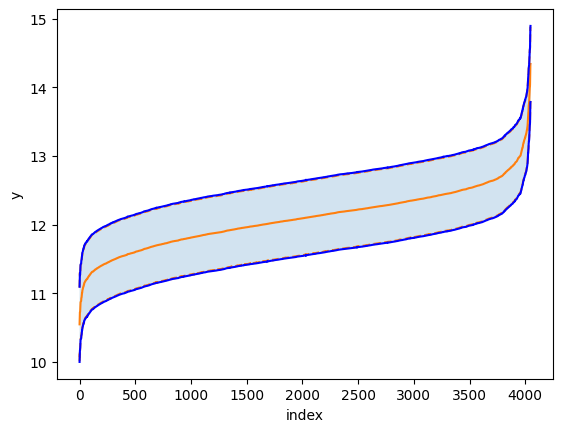

In [14]:
idx = np.arange(len(y_pred))

plt.xlabel("index")
plt.ylabel("y")
# plt.scatter(idx, y[order], alpha=0.2)
order = np.argsort(y_pred)
plt.plot(idx, y_pred[order], color="C1")
plt.plot(idx, yp_conf_ci.iloc[order]['lower'], color="C1", ls="--")
plt.plot(idx, yp_conf_ci.iloc[order]['upper'], color="C1", ls="--")
plt.plot(idx, ols_l[order], color="blue", ls="-")
plt.plot(idx, ols_u[order], color="blue", ls="-")
plt.fill_between(
    idx,
    yp_conf_ci.iloc[order]['lower'].ravel(),
    yp_conf_ci.iloc[order]['upper'].ravel(),
    alpha=0.2
)
# plt.title(
#     f"Target and effective coverages for "
#     f"alpha={alpha[0]:.2f}: ({1-alpha[0]:.3f}, {coverage_scores[0]:.3f})\n"
#     f"Target and effective coverages for "
#     f"alpha={alpha[1]:.2f}: ({1-alpha[1]:.3f}, {coverage_scores[1]:.3f})"
# )
plt.show()

## Bootstrap

In [15]:
def bootstrap_prediction(X, y, X_new, nboot=100, alpha=0.1):
    
    predictions = np.empty(shape = (X_new.shape[0], 1))

    for i in np.arange(nboot):
        X_b, y_b = resample(X, y, replace=True)
        fit = LinearRegression().fit(X_b, y_b)
        resid = fit.predict(X_b) - y_b
        # ideally we'd use hat/leverage values to get variance adjusted resid
        #  a la https://stats.stackexchange.com/questions/226565/bootstrap-prediction-interval
        # and ?boot in R
        # X_b = np.asarray(X_b)
        # hat = np.diag(X_b @ np.linalg.pinv(X_b.T @ X_b) @ X_b.T)
        # resid = resid / np.sqrt(1 - hat)
        bootstrap_prediction = fit.predict(X_new) + np.random.choice(resid, 1)
        predictions = np.hstack((predictions, bootstrap_prediction.reshape(-1, 1)))

    # Find the ends of the approximate 95% prediction interval
    lower = np.apply_along_axis(lambda x: np.percentile(x, 100*(alpha/2)), 1, predictions[:,1:])
    upper = np.apply_along_axis(lambda x: np.percentile(x, 100*(1 - alpha/2)), 1, predictions[:,1:])

    # return(bs)
    return(dict(lower = lower, upper = upper, predictions = predictions))
    # return(predictions)

In [16]:
boot_result = bootstrap_prediction(X_train, y_train, X_test, nboot=500, alpha=0.1)

In [19]:
# boot_result2 = BaggingRegressor(LinearRegression(), n_estimators=100).fit(X_train, y_train)#.predict(X_test)
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html

In [17]:
pd.DataFrame({
    'y': y_test,
    'y_pred_boot': np.apply_along_axis(np.mean, 1, boot_result['predictions']),
    'y_pred': y_pred,
    'y_pred_ols': np.array(ols_fit.predict(sm.add_constant(X_test))).flatten(),
}).corr()
    

,y,y_pred_boot,y_pred,y_pred_ols
y,1.000000,0.237817,0.807178,0.807178
y_pred_boot,0.237817,1.000000,0.295594,0.295594
y_pred,0.807178,0.295594,1.000000,1.000000
y_pred_ols,0.807178,0.295594,1.000000,1.000000


In [21]:
# pd.DataFrame({'lower':ols_l, 'upper':ols_u}).assign(diff= lambda x: x.upper - x.lower).describe()

In [18]:
yp_boot = pd.DataFrame({'lower': boot_result['lower'], 'upper': boot_result['upper']})#.assign(diff= lambda x: x.upper - x.lower)
yp_boot.describe()

,lower,upper
count,4048.000000,4048.000000
mean,11.595067,12.638641
std,0.435935,0.438590
min,10.025079,11.081815
25%,11.312710,12.352108
50%,11.594611,12.637555
75%,11.862386,12.907979
max,13.836439,14.937588


/var/folders/x6/4jhswqxj0sqf_gkgq6lw6l880000gn/T/ipykernel_82493/2674959199.py:16: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  yp_conf_ci.iloc[order]['lower'].ravel(),
/var/folders/x6/4jhswqxj0sqf_gkgq6lw6l880000gn/T/ipykernel_82493/2674959199.py:17: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  yp_conf_ci.iloc[order]['upper'].ravel(),


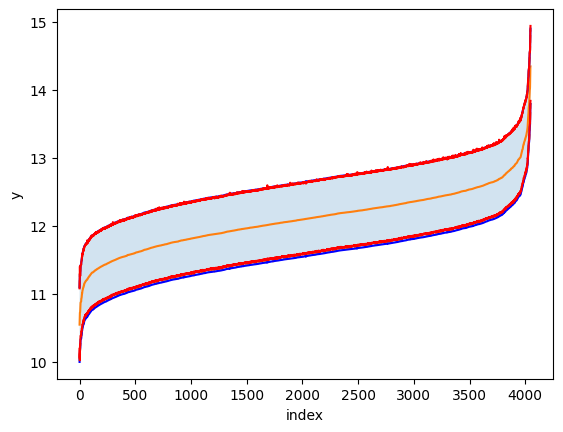

In [19]:
idx = np.arange(len(y_pred))

plt.xlabel("index")
plt.ylabel("y")
# plt.scatter(idx, y[order], alpha=0.2)
order = np.argsort(y_pred)
plt.plot(idx, y_pred[order], color="C1")
plt.plot(idx, yp_conf_ci.iloc[order]['lower'], color="C1", ls="--")
plt.plot(idx, yp_conf_ci.iloc[order]['upper'], color="C1", ls="--")
plt.plot(idx, ols_l[order], color="blue", ls="-")
plt.plot(idx, ols_u[order], color="blue", ls="-")
plt.plot(idx, yp_boot['lower'][order], color="red", ls="-")
plt.plot(idx, yp_boot['upper'][order], color="red", ls="-")
plt.fill_between(
    idx,
    yp_conf_ci.iloc[order]['lower'].ravel(),
    yp_conf_ci.iloc[order]['upper'].ravel(),
    alpha=0.2
)
# plt.title(
#     f"Target and effective coverages for "
#     f"alpha={alpha[0]:.2f}: ({1-alpha[0]:.3f}, {coverage_scores[0]:.3f})\n"
#     f"Target and effective coverages for "
#     f"alpha={alpha[1]:.2f}: ({1-alpha[1]:.3f}, {coverage_scores[1]:.3f})"
# )
plt.show()

In [22]:
df_results = pd.concat(
    [
        yp_ols.rename(columns={'mean': 'y_pred', 'obs_ci_lower': 'ols_lower', 'obs_ci_upper': 'ols_upper'}),
        yp_conf_ci.rename(columns={'lower': 'conf_lower', 'upper': 'conf_upper'}),
        yp_boot.rename(columns={'lower': 'boot_lower', 'upper': 'boot_upper'})
    ],
    axis=1
).assign(
    y = y_test,
    median_house_value = np.exp(y_test)
)

In [23]:
df_results

,y_pred,ols_lower,ols_upper,conf_lower,conf_upper,boot_lower,boot_upper,y,median_house_value
0,12.181823,11.634365,12.729281,114064.678138,334130.571891,117318.350598,334936.209533,12.420781,247900.0
1,11.788304,11.240811,12.335797,76948.608710,225481.648323,79266.565261,224844.648223,11.569306,105800.0
2,12.535255,11.987798,13.082713,162394.495508,475744.760541,168052.607255,475440.730475,12.612537,300300.0
3,11.609471,11.062006,12.156936,64302.654639,188429.880023,66826.585467,187124.904231,10.909619,54700.0
4,12.074952,11.527518,12.622386,102502.046789,300281.986919,106136.992471,300209.796585,12.112311,182100.0
...,...,...,...,...,...,...,...,...,...
4043,12.804741,12.257202,13.352281,212718.066777,623000.205356,220098.049683,623300.370811,12.679508,321100.0
4044,12.552368,12.004852,13.099885,165152.180151,483829.943252,171584.782538,482876.070056,12.721587,334900.0
4045,11.818883,11.271421,12.366346,79357.782477,232344.884093,81790.633781,233138.664292,11.998433,162500.0
4046,13.003689,12.456095,13.551283,259440.165738,760127.763478,266404.641483,762462.625486,12.874158,390100.0


In [24]:
# # df_results.head()
# df_results.to_csv('data/housing_CI_results.csv', index=False)

# X_train.to_csv('data/housing_X_train.csv', index=False)
# y_train.to_csv('data/housing_y_train.csv', index=False)
# X_test.to_csv('data/housing_X_test.csv', index=False)
# y_test.to_csv('data/housing_y_test.csv', index=False)

## Boosting

In [25]:
# from sklearn.ensemble import HistGradientBoostingRegressor


In [26]:
# test_fit_boost = xgb.XGBRegressor(n_estimators=250).fit(X_train, y_train).predict(X_test) # timing
# test_fit_lr = LinearRegression().fit(X_train, y_train).predict(X_test) # timing

# from sklearn.metrics import mean_squared_error

# (mean_squared_error(y_test, test_fit_boost, squared=False), mean_squared_error(y_test, test_fit_lr, squared=False))


In [27]:
parameters = {
    'nthread':[4], 
    'objective':['reg:squarederror'],
    'learning_rate': [.001, .03, .1], #so called `eta` value
    'max_depth': [5, 10],
    'min_child_weight': [10, 20],
    'subsample': [0.7, 1],
    'colsample_bytree': [0.7, 1],
    'n_estimators': [500]
    }

xgb_grid = HalvingRandomSearchCV(
    xgb.XGBRegressor(),
    parameters,
    cv      = 5,
    # n_jobs  = 4,
    verbose = 1
)

xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 7
min_resources_: 10
max_resources_: 16190
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 48
n_resources: 10
Fitting 5 folds for each of 48 candidates, totalling 240 fits


/Users/micl/anaconda3/envs/m-clark-github-io/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 48 is smaller than n_iter=1619. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


----------
iter: 1
n_candidates: 16
n_resources: 30
Fitting 5 folds for each of 16 candidates, totalling 80 fits
----------
iter: 2
n_candidates: 6
n_resources: 90
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 3
n_candidates: 2
n_resources: 270
Fitting 5 folds for each of 2 candidates, totalling 10 fits
0.6449807081357619
{'subsample': 1, 'objective': 'reg:squarederror', 'nthread': 4, 'n_estimators': 500, 'min_child_weight': 10, 'max_depth': 10, 'learning_rate': 0.03, 'colsample_bytree': 0.7}


In [28]:
boost_ca = MapieRegressor(xgb.XGBRegressor(**xgb_grid.best_params_)).fit(X_train, y_train)
boost_ca.predict(X_test)
y_pred_boost, yp_conf_ci = boost_ca.predict(X_test, alpha=0.1)
yp_conf_ci = pd.DataFrame(yp_conf_ci[:,:,0], columns=['lower', 'upper']).reset_index(drop=True)

In [32]:
# yp_conf_ci['lower']

In [29]:
def bootstrap_prediction(X, y, X_new, nboot=100, alpha=0.1):
    
    predictions = np.empty(shape = (X_new.shape[0], 1))

    for i in np.arange(nboot):
        X_b, y_b = resample(X, y, replace=True)
        fit = xgb.XGBRegressor(**xgb_grid.best_params_).fit(X_b, y_b)
        resid = fit.predict(X_b) - y_b
        # ideally we'd use hat/leverage values to get variance adjusted resid
        #  a la https://stats.stackexchange.com/questions/226565/bootstrap-prediction-interval
        # and ?boot in R
        # X_b = np.asarray(X_b)
        # hat =  np.diag(X_b @ np.linalg.pinv(X_b.T @ X_b) @ X_b.T)
        # resid = resid / np.sqrt(1 - hat)
        bootstrap_prediction = fit.predict(X_new) + np.random.choice(resid, 1)
        predictions = np.hstack((predictions, bootstrap_prediction.reshape(-1, 1)))

    # Find the ends of the approximate 95% prediction interval
    prediction_mean = np.apply_along_axis(np.mean, 1, predictions[:,1:])
    lower = np.apply_along_axis(lambda x: np.percentile(x, 100*(alpha/2)), 1, predictions[:,1:])
    upper = np.apply_along_axis(lambda x: np.percentile(x, 100*(1 - alpha/2)), 1, predictions[:,1:])

    # return(bs)
    return(dict(lower = lower, upper = upper, prediction = prediction_mean))
    # return(predictions)

In [30]:
boot_result = bootstrap_prediction(X_train, y_train, X_test, nboot=500, alpha=0.1)  # roughly 2 min for 100

In [31]:
yp_boot = pd.DataFrame({'lower': boot_result['lower'], 'upper': boot_result['upper']})#.assign(diff= lambda x: x.upper - x.lower)
yp_boot.describe()

,lower,upper
count,4048.000000,4048.000000
mean,11.943679,12.242258
std,0.487859,0.478199
min,10.755906,11.021132
25%,11.591447,11.909220
50%,11.960027,12.252566
75%,12.283351,12.576765
max,13.108787,13.389138


### Quantile Boost

Unfortunately we get lib errors

In [36]:
# quantile_boost_ca = xgb.XGBRegressor(n_estimators=250, objective='reg:quantileerror', quantile_alpha = .05).fit(X_train, y_train)

### Plot

/var/folders/x6/4jhswqxj0sqf_gkgq6lw6l880000gn/T/ipykernel_88145/3937513493.py:18: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  yp_conf_ci.iloc[order_boost]['lower'].ravel(),
/var/folders/x6/4jhswqxj0sqf_gkgq6lw6l880000gn/T/ipykernel_88145/3937513493.py:19: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  yp_conf_ci.iloc[order_boost]['upper'].ravel(),


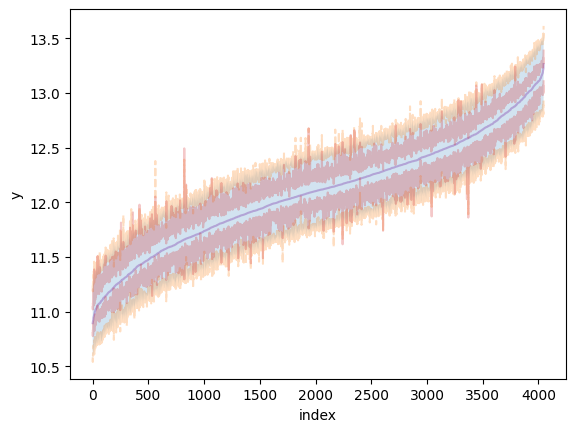

In [37]:
idx = np.arange(len(y_pred))

order = np.argsort(y_pred)
order_boost = np.argsort(y_pred_boost)

plt.xlabel("index")
plt.ylabel("y")
# plt.scatter(idx, y[order], alpha=0.2)
plt.plot(idx, y_pred_boost[order_boost], color="C4", alpha = .5)
plt.plot(idx, yp_conf_ci.iloc[order_boost]['lower'], color="C1", ls="--", alpha = .25)
plt.plot(idx, yp_conf_ci.iloc[order_boost]['upper'], color="C1", ls="--", alpha = .25)
# plt.plot(idx, ols_l[order], color="blue", ls="-")
# plt.plot(idx, ols_u[order], color="blue", ls="-")
plt.plot(idx, yp_boot['lower'][order_boost], color="C3", ls="-", alpha = .25)
plt.plot(idx, yp_boot['upper'][order_boost], color="C3", ls="-", alpha = .25)
plt.fill_between(
    idx,
    yp_conf_ci.iloc[order_boost]['lower'].ravel(),
    yp_conf_ci.iloc[order_boost]['upper'].ravel(),
    alpha=0.2
)
# plt.title(
#     f"Target and effective coverages for "
#     f"alpha={alpha[0]:.2f}: ({1-alpha[0]:.3f}, {coverage_scores[0]:.3f})\n"
#     f"Target and effective coverages for "
#     f"alpha={alpha[1]:.2f}: ({1-alpha[1]:.3f}, {coverage_scores[1]:.3f})"
# )
plt.show()

In [38]:
df_boost_results = pd.concat(
    [
        yp_ols.rename(columns={'mean': 'y_pred', 'obs_ci_lower': 'ols_lower', 'obs_ci_upper': 'ols_upper'}),
        yp_conf_ci.rename(columns={'lower': 'conf_lower', 'upper': 'conf_upper'}),
        yp_boot.rename(columns={'lower': 'boot_lower', 'upper': 'boot_upper'})
    ],
    axis=1
).assign(
    y = y_test,
    y_pred_boost = y_pred_boost,
    y_pred_boot = boot_result['prediction'],
    median_house_value = np.exp(y_test)
).rename(
    columns={'y_pred': 'y_pred_ols'}
)

In [39]:
coverage_scores = [
    dict(
        boost_cov = np.round(regression_coverage_score(y_test, df_boost_results['conf_lower'], df_boost_results['conf_upper']), 4),
        boot_cov  = np.round(regression_coverage_score(y_test, df_boost_results['boot_lower'], df_boost_results['boot_upper']), 4)
    )
    for i, _ in enumerate([.1])
]

pd.DataFrame(coverage_scores)

,boost_cov,boot_cov
0,0.9219,0.6168


In [40]:
df_boost_results[['y_pred_ols', 'y_pred_boost', 'y_pred_boot']].corr(method='spearman')

,y_pred_ols,y_pred_boost,y_pred_boot
y_pred_ols,1.000000,0.893664,0.901034
y_pred_boost,0.893664,1.000000,0.996352
y_pred_boot,0.901034,0.996352,1.000000


In [ ]:
# # df_results.head()
# df_boost_results.to_csv('data/housing_CI_boost_results.csv', index=False)
# pd.DataFrame(coverage_scores).to_csv('data/housing_CI_boost_coverage.csv', index=False)